In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))



# Dimensionality Reduction

### Doing PCA manually using SVD

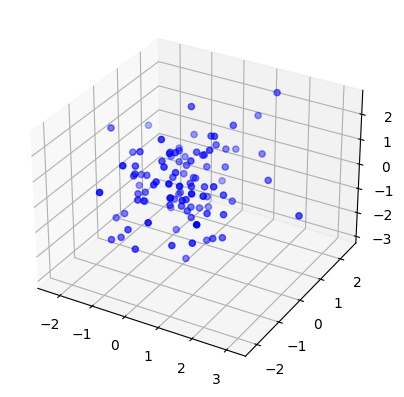

In [29]:
# 3D dataset
num_points = 100
X = np.random.randn(num_points, 3) 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c='b', marker='o', label='Data Points')


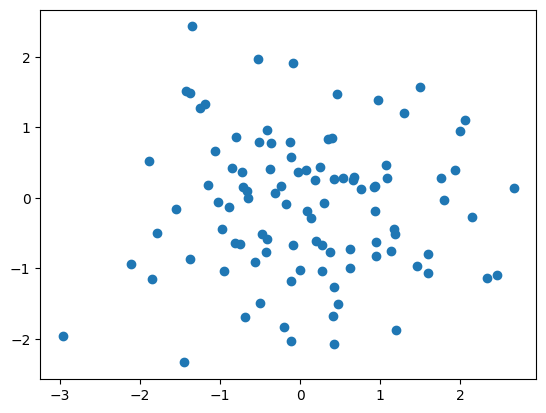

In [30]:
# We first center the dataset around the origin (centered around 0)
X_centered = X - X.mean(axis=0)

# SVD and getting the first two PCs
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]
W_d = np.c_[c1, c2]

# Projecting to a 2D space
X_proj = X @ W_d

# Visualizing 
plt.scatter(X_proj[:,0], X_proj[:,1])


### Dimensionality reduction using scikit-learn

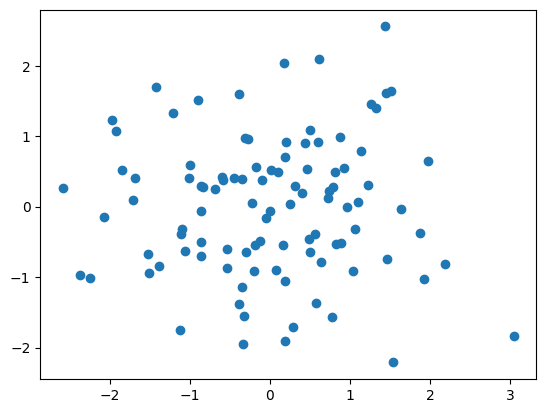

In [31]:
# Automatically takes care of centering the data
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

# The PCs
W_d = pca.components_

# Visualizing 
plt.scatter(X2D[:,0], X2D[:,1])

In [33]:
# Explained variance ratio

# How is the variance distributed amongst the PCs
pca.explained_variance_ratio_

array([0.40508339, 0.32030793])

### MNIST - dimensionality reduction using PCA

In [38]:
# Get MNIST and split

mnist = fetch_openml('mnist_784', as_frame=True)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [44]:
# Getting the minimum number of dimensions to maintain a variance of 95% (done manually)

pca = PCA()
pca.fit(X_train)

# We compute the cumulative sum of items in the variance ration array (e.g. [1,2,3] cumsum -> [1, 3, 6]).
# We then get the first index where the cum sum is 0.95 or more. That's the number of dimensions we can keep
# in order to satisfy the variance requirement of 0.95.
cumsum = np.cumsum(pca.explained_variance_ratio_)

# We can use this index as the n_components when creating the PCA object. Or, we can simply specify it as the n_components
# (see below example)
d = np.argmax(cumsum >= 0.95) + 1

print (f"Minimum number of dimensions to maintain a variance of 95%: {d}")

Minimum number of dimensions to maintain a variance of 95%: 154


In [45]:
# Getting the minimum number of dimensions to maintain a variance of 95% (done automatically)

pca = PCA(n_components=0.95)
pca.fit(X_train)

print (f"Minimum number of dimensions to maintain a variance of 95%: {len(pca.components_)}")


Minimum number of dimensions to maintain a variance of 95%: 154


In [48]:
# We can plot the cumsum of the variance ratio to get an elbow curve for how the variance grows as more
# dimensions are considered

pca = PCA()
pca.fit(X_train)

var_cumsum = np.cumsum(pca.explained_variance_ratio_)

len(var_cumsum)

784

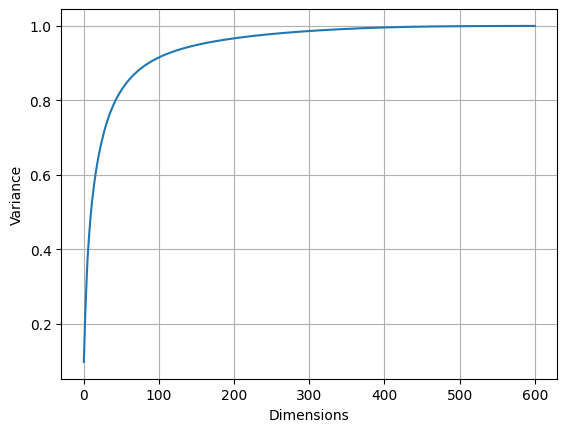

In [54]:
dim_limit = 600
X_dims = np.linspace(0, dim_limit, dim_limit)

plt.plot(X_dims, var_cumsum[:dim_limit])
plt.xlabel("Dimensions")
plt.ylabel("Variance")
plt.grid()

### Building a training pipeline with PCA in it

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

# PCA then random forest
clf = make_pipeline(
  PCA(random_state=42),
  RandomForestClassifier(random_state=42)
)

# Randomized search for the best number of dims and forest hyperparameters
param_dist = {
  "pca__n_components": np.arange(10,80),
  "randomforestclassifier__n_estimators": np.arange(50,500)
}

rnd_search = RandomizedSearchCV(clf, param_dist, n_iter=2, cv=3, random_state=42, verbose=3)
rnd_search.fit(X_train[:1000], y_train[:1000])


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END pca__n_components=62, randomforestclassifier__n_estimators=304;, score=0.862 total time=   8.3s
[CV 2/3] END pca__n_components=62, randomforestclassifier__n_estimators=304;, score=0.856 total time=   8.3s
[CV 3/3] END pca__n_components=62, randomforestclassifier__n_estimators=304;, score=0.850 total time=   8.4s
[CV 1/3] END pca__n_components=45, randomforestclassifier__n_estimators=95;, score=0.832 total time=   7.1s
[CV 2/3] END pca__n_components=45, randomforestclassifier__n_estimators=95;, score=0.868 total time=   7.5s
[CV 3/3] END pca__n_components=45, randomforestclassifier__n_estimators=95;, score=0.841 total time=   7.4s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=2,
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42, verbose=3)

In [60]:
print (rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 304, 'pca__n_components': 62}


### Reconstructing the original dataset from the reduced one

In [61]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

print (X_reduced.shape)

(60000, 154)


In [63]:
X_recovered = pca.inverse_transform(X_reduced)
print (X_recovered.shape)

(60000, 784)


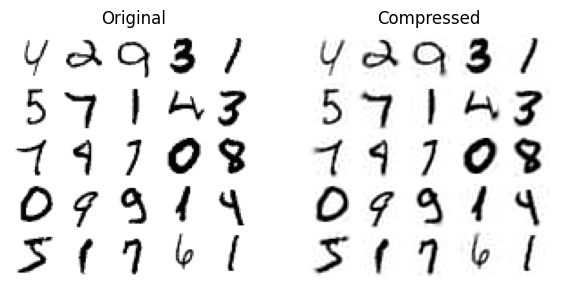

In [71]:
# Plotting the original data vs the recovered one. We can see that some image quality is lost in the recovered set

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    X = np.array(X)
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")


### Incremental PCA

In [72]:
from sklearn.decomposition import IncrementalPCA

# Fitting PCA in batches using IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for x_batch in np.array_split(X_train, n_batches):
  inc_pca.fit(x_batch)

# Reducing dimensionality of dataset like before
X_reduced = inc_pca.transform(X_train)
X_reduced.shape

(60000, 154)

### Memory mapped files to deal with a dataset that's too large to fit in memory

The `X_mmap` data structure works with a memory mapped file which can load data to memory as needed.

In [83]:
filename = "mnist.mmap"
X_mmap = np.memmap(filename, dtype="float32", mode="write", shape=X_train.shape)

# This could be a loop reading the dataset from disk and populating the mmap array
chunk_size = 1024
m = 60_000
for i in range(m):
  start_i = i * chunk_size
  end_i = (i+1)*chunk_size

  if start_i >= m: break

  # Here we would read from disk the chunk instead
  chunk_i = X_train[start_i:end_i]
  X_mmap[start_i:end_i] = chunk_i

# flush saves any data that's in cache to the mmap file on disk
X_mmap.flush()
X_mmap.shape

(60000, 784)

In [86]:
# We can now load the mmap file and use incremental PCA to fit it.
# Need to reshape it because it comes back flattened
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)

# Get the batch size
batch_size = X_mmap.shape[0] // n_batches

# This will use the mmaped file to fit the PCA incrementally. It will load from disk as needed
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)


IncrementalPCA(batch_size=600, n_components=154)

# Locally Linear Embeddings (LLE)

(1000, 2)


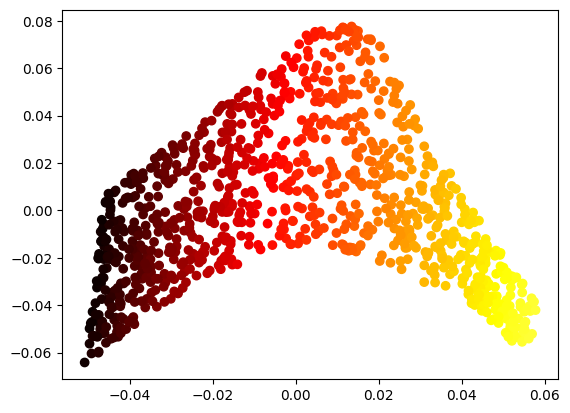

In [97]:
# The swiss roll is a 3D manifold dataset.
# t is a 1D vector containing the position of each instance along the rolled axis
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# LLE model to reduce the data to 2D
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

print (X_unrolled.shape)

plt.scatter(X_unrolled[:,0], X_unrolled[:,1], c=t, cmap=darker_hot)

(1000, 3)